<!-- <img src="./logo_UTN.svg" align="right" width="150" />  -->
<img src="Logo_UNSAM.png" align="right" width="150" />  -->
#### An√°lisis y Procesamiento Digital de Se√±ales

# Tarea Semanal N¬∞07
#### Montserrat Coto



## Introducci√≥n



El an√°lisis de se√±ales electrocardiogr√°ficas (ECG) requiere t√©cnicas de procesamiento digital que permitan eliminar interferencias sin comprometer la integridad morfol√≥gica de la se√±al. En esta tarea se parte del archivo ecg.mat, que contiene un registro de ECG real adquirido durante una prueba de esfuerzo, con una frecuencia de muestreo de *1‚ÄØkHz* y acompa√±ado por variables de referencia como localizaci√≥n de latidos *(qrs_detections)* y plantillas promedio de latidos normales y ventriculares.

El objetivo principal es dise√±ar y aplicar filtros digitales que permitan mitigar tres fuentes t√≠picas de contaminaci√≥n:

- Ruido muscular y por movimiento de electrodos (ambos en alta frecuencia).

- Movimiento de la l√≠nea de base causado por la respiraci√≥n (baja frecuencia).

Para ello, se estableci√≥ una plantilla de dise√±o basada en el ancho de banda estimado del ECG (seg√∫n lo trabajado en la Tarea Semanal 5) y se tomaron como referencia morfolog√≠as promedio provistas (heartbeat_pattern1, heartbeat_pattern2 y qrs_pattern1) para evaluar la efectividad de los filtros en cuanto a suavidad y nivel isoel√©ctrico.

Se dise√±aron al menos dos filtros IIR (Butterworth y Cauer, aproximaciones de m√°xima planicidad y de m√≠nima banda de transici√≥n, respectivamente) y dos FIR (uno con ventana de Kaiser y otro por m√≠nimos cuadrados), todos implementados con funciones de scipy.signal.

Finalmente, se analiz√≥ su desempe√±o desde m√∫ltiples perspectivas:

- La respuesta en frecuencia de cada filtro y su adecuaci√≥n a la plantilla deseada.

- La atenuaci√≥n de se√±ales interferentes (alta o baja frecuencia).

- La preservaci√≥n de la se√±al √∫til en zonas sin contaminaci√≥n, evaluando qu√© tan inocuo es el filtrado.

- El impacto en la morfolog√≠a de los latidos, especialmente en la forma del complejo QRS y la l√≠nea de base.

Esta tarea busca no s√≥lo cumplir con los requisitos t√©cnicos de la consigna, sino tambi√©n reflexionar sobre las limitaciones pr√°cticas del dise√±o de filtros digitales en contextos reales, evaluando c√≥mo se comportan frente a se√±ales fisiol√≥gicas complejas y con diferentes tipos de ruido presentes.

# Desarollo

##### Definici√≥n de Par√°metros

In [72]:
import numpy as np
import scipy.io as sio
import scipy.signal as sig
from scipy.fft import fft, fftshift
import matplotlib.pyplot as plt
from pytc2.sistemas_lineales import plot_plantilla
from scipy.signal import sosfreqz, group_delay
from pytc2.filtros_digitales import fir_design_ls

plt.close('all')

##################
#%% Lectura de ECG #
##################

fs_ecg = 1000  # Hz
mat_struct = sio.loadmat('./ECG_TP4.mat')
ecg_one_lead = mat_struct['ecg_lead'].flatten()
nyq_frec = fs_ecg / 2  # Frecuencia de Nyquist

# Variables del archivo mat_struct
qrs_pattern = mat_struct['qrs_pattern1'].flatten()
heartbeat_normal = mat_struct['heartbeat_pattern1'].flatten()
heartbeat_ventricular = mat_struct['heartbeat_pattern2'].flatten()
qrs_locations = mat_struct['qrs_detections'].flatten()

ecg_one_lead = ecg_one_lead / np.std(ecg_one_lead)
heartbeat_normal = heartbeat_normal / np.std(heartbeat_normal)
heartbeat_ventricular = heartbeat_ventricular / np.std(heartbeat_ventricular)
qrs_pattern = qrs_pattern /np.std(qrs_pattern)



ModuleNotFoundError: No module named 'pytc2.filtros_digitales'

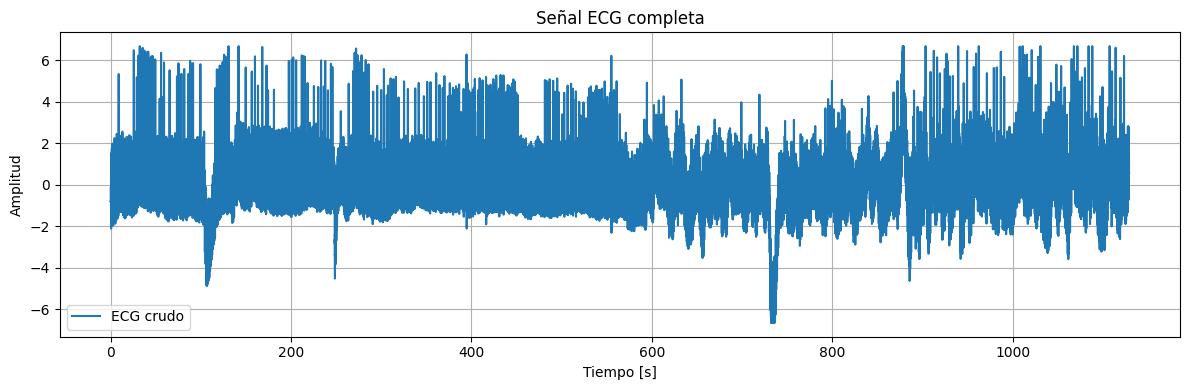

In [73]:
#%% Visualizaci√≥n se√±al completa

plt.figure(figsize=(12, 4))
t_total = np.arange(len(ecg_one_lead)) / fs_ecg
plt.plot(t_total, ecg_one_lead, label='ECG crudo')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')
plt.title('Se√±al ECG completa')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

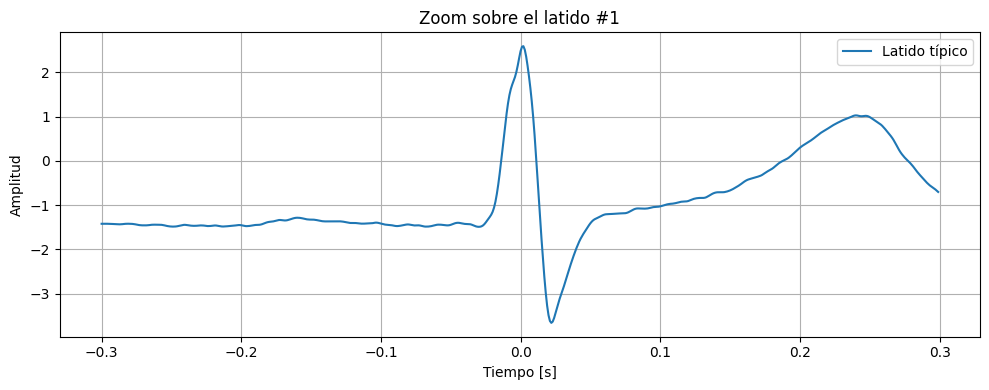

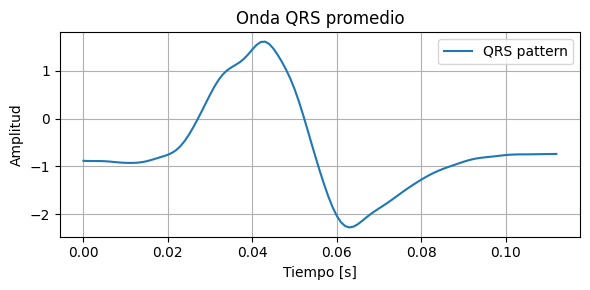

In [57]:
#%% Visualizaci√≥n latido t√≠pico

i = 0
sample_center = int(qrs_locations[i])
window_size = 0.6  # segundos (¬±300 ms)
N = int(window_size * fs_ecg)

ecg_segment = ecg_one_lead[sample_center - N // 2 : sample_center + N // 2]
ecg_segment = ecg_segment / np.std(ecg_segment)
t_segment = np.arange(-N//2, N//2) / fs_ecg

plt.figure(figsize=(10, 4))
plt.plot(t_segment, ecg_segment, label='Latido t√≠pico')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')
plt.title(f'Zoom sobre el latido #{i + 1}')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

#%% Visualizaci√≥n QRS


plt.figure(figsize=(6, 3))
plt.plot(np.arange(len(qrs_pattern)) / fs_ecg, qrs_pattern, label='QRS pattern')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')
plt.title('Onda QRS promedio')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

**Visualizaci√≥n del latido t√≠pico:**  
Este gr√°fico permite identificar con la duraci√≥n y forma general del latido, especialmente del complejo QRS, as√≠ como las ondas P y T que lo rodean. Esta informaci√≥n es √∫til para definir las bandas de frecuencia que debe preservar el filtro y evitar distorsionar las componentes clave del ECG.

**Latido promedio normal y ventricular:**  
Al comparar el latido promedio de ritmos normales y ventriculares, se observan diferencias en morfolog√≠a y duraci√≥n que pueden influir en la selecci√≥n del ancho de banda del filtro, ya que el filtro debe ser lo suficientemente flexible para preservar las caracter√≠sticas de ambos tipos.

**Onda QRS promedio:**  
Muestra la duraci√≥n t√≠pica, lo que ayuda a determinar la frecuencia m√°xima relevante que el filtro debe mantener. Esto es crucial para dise√±ar un filtro que permita la detecci√≥n precisa del QRS sin atenuar sus componentes importantes ni introducir retrasos significativos.


## 1. Filtro IIR

### A y B) Plantilla de dise√±o para los filtros digitales que necesitar√° para que la se√±al de ECG

### b) Establecimiento de la plantilla de dise√±o para filtros digitales

Se dise√±aron dos filtros digitales pasabanda IIR utilizando la aproximaci√≥n de Butterworth (m√°xima planicidad) y Cauer mediante la funci√≥n `iirdesign` de SciPy. 

Para el dise√±o de la plantilla, se eligieron:

- **Frecuencias de paso entre 0.5 Hz y 30 Hz**:  
  El l√≠mite inferior de 0.5 Hz permite preservar el contenido √∫til del ECG, mientras se eliminan componentes de muy baja frecuencia, como el desplazamiento de l√≠nea base causado por movimientos respiratorios o el desplazamiento de electrodos.  
  El l√≠mite superior de 30 Hz se defini√≥ a partir del an√°lisis espectral realizado en la TS05, donde se observ√≥ que el 98% de la energ√≠a estaba por debajo de 27.5 Hz. Se agreg√≥ un peque√±o margen para asegurar la conservaci√≥n de componentes de inter√©s.

- **Bandas de detenci√≥n por debajo de 0.1 Hz y por encima de 50 Hz**:  
  La banda de rechazo inferior (< 0.1 Hz) garantiza la eliminaci√≥n efectiva de variaciones lentas no fisiol√≥gicas.  
  La banda de rechazo superior (> 50 Hz) busca filtrar el ruido de la red el√©ctricaa. Adem√°s, las frecuencias por encima de 50 Hz no aportan informaci√≥n relevante sobre los latidos y solo introducen ruido de alta frecuencia.

- **Rizado m√°ximo en banda de paso (Œ±_max): 0.5 dB**  
  Se permite un rizado de hasta 0.5 dB en la banda de paso, lo cual representa una peque√±a variaci√≥n de ganancia que no afecta significativamente la morfolog√≠a de los latidos. 

- **Atenuaci√≥n m√≠nima en banda de detenci√≥n (Œ±_min): 40 dB**  
  Se requiere una atenuaci√≥n de al menos 40 dB para asegurar que las componentes fuera de banda se reduzcan lo suficiente.  
  Este valor equivale a una atenuaci√≥n de 100 veces en amplitud, lo que corresponde a una d√©cada, es decir, una reducci√≥n de un orden de magnitud.

A continuaci√≥n, se presenta la plantilla de dise√±o junto con la respuesta en frecuencia del filtro.  
Se utiliza una grilla de frecuencias con mayor resoluci√≥n entre 0.5 Hz y 1.2 Hz para observar m√°s claramente la transici√≥n en bajas frecuencias, regi√≥n cr√≠tica para asegurar la eliminaci√≥n del desplazamiento de l√≠nea base sin afectar los primeros arm√≥nicos del ECG.


### ----------- Aproximaci√≥n de m√°xima planicidad (Butterworth) -----------

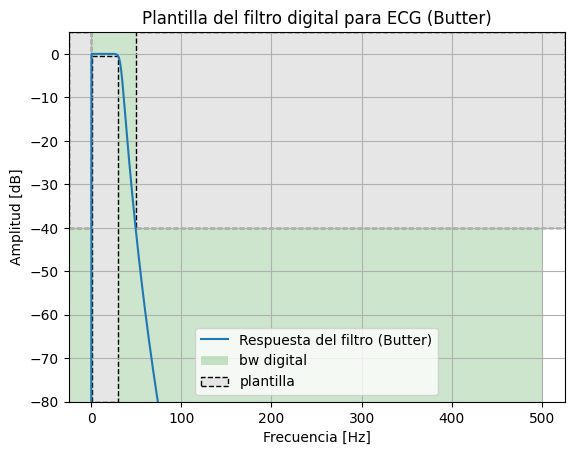

In [64]:

filter_type = 'bandpass'


# # ----------- Aproximaci√≥n de m√°xima planicidad (Butterworth) -----------
# # Descomentar esta l√≠nea para usar Butterworth (m√°xima planicidad)
aprox_name = 'butter'
mi_sos_butter = sig.iirdesign(
    wp=[0.5, 30],
    ws=[0.1, 50],
    gpass=0.5,
    gstop=40,
    ftype=aprox_name,
    output='sos',
    fs=fs_ecg
)
fpass = np.array([0.5, 30])      # Banda de paso
fstop = np.array([0.1, 50])      # Banda de detenci√≥n
ripple = 0.5                     # Rizado en banda de paso (dB)
attenuation = 40                # Atenuaci√≥n en banda de detenci√≥n (dB)


# Dise√±o del filtro (estructura en SOS)
mi_sos_butter = sig.iirdesign(
    wp=fpass,
    ws=fstop,
    gpass=ripple,
    gstop=attenuation,
    ftype=aprox_name,
    output='sos',
    fs=fs_ecg
)


ecg_filtrada_butter = sig.sosfiltfilt(mi_sos_butter, ecg_segment)
ecg_filtrada_butter = ecg_filtrada_butter / np.std(ecg_filtrada_butter)

#%% Visualizaci√≥n de plantilla y respuesta en frecuencia

f_low = np.linspace(0.01, 0.4, 300)
f_fine = np.linspace(0.4, 0.6, 500)
f_high = np.linspace(0.6, nyq_frec, 700)
f_total = np.concatenate((f_low, f_fine, f_high))

w_rad = f_total / nyq_frec * np.pi
w, hh = sosfreqz(mi_sos_butter, worN=w_rad)

plt.figure()
plt.plot(w / np.pi * nyq_frec, 20 * np.log10(np.abs(hh) + 1e-15),
         label=f'Respuesta del filtro (Butter)')
plt.title(f'Plantilla del filtro digital para ECG (Butter)')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Amplitud [dB]')
plt.grid(True)
plt.ylim([-80, 5])

plot_plantilla(
    filter_type=filter_type,
    fpass=fpass,
    ripple=ripple,
    fstop=fstop,
    attenuation=attenuation,
    fs=fs_ecg
)

plt.show()




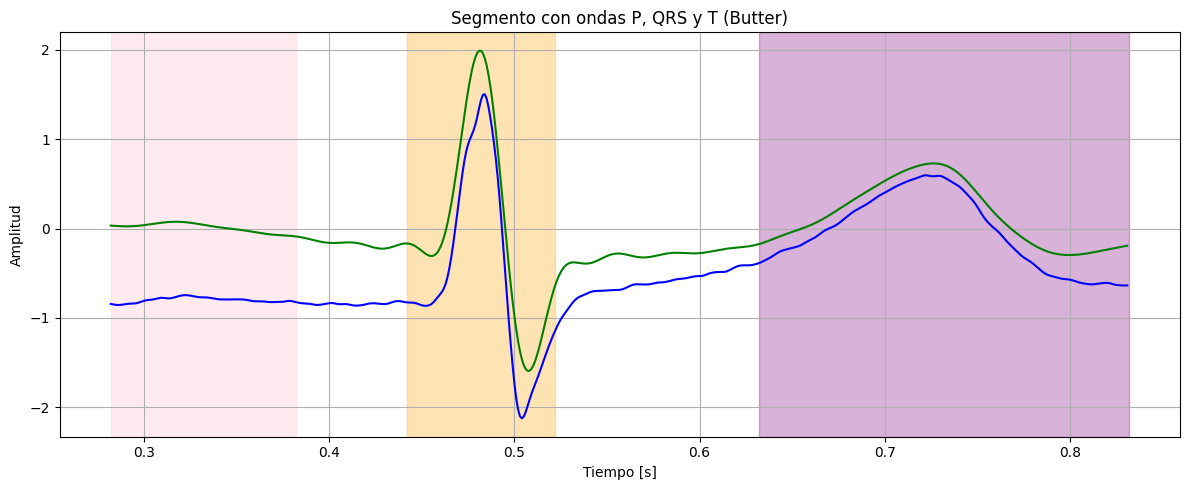

In [61]:


#%% Visualizaci√≥n segmento con ondas P, QRS y T

# Par√°metros para ventanas de las ondas (en segundos)
p_start_sec = -0.2  # 200 ms antes del QRS (inicio P)
p_end_sec = -0.1    # 100 ms antes del QRS (fin P)

qrs_start_sec = -0.04  # 40 ms antes del QRS (inicio QRS)
qrs_end_sec = 0.04     # 40 ms despu√©s del QRS (fin QRS)

t_start_sec = 0.15    # 150 ms despu√©s del QRS (inicio T)
t_end_sec = 0.35      # 350 ms despu√©s del QRS (fin T)

# Muestras relativas
sample_center = int(qrs_locations[0])
p_start = sample_center + int(p_start_sec * fs_ecg)
p_end = sample_center + int(p_end_sec * fs_ecg)

qrs_start = sample_center + int(qrs_start_sec * fs_ecg)
qrs_end = sample_center + int(qrs_end_sec * fs_ecg)

t_start = sample_center + int(t_start_sec * fs_ecg)
t_end = sample_center + int(t_end_sec * fs_ecg)

# Extraemos un segmento amplio para visualizar
start_segment = p_start
end_segment = t_end

ecg_segment_full = ecg_one_lead[start_segment:end_segment]
t_segment_full = np.arange(start_segment, end_segment) / fs_ecg
ecg_filtrada_butter_full = sig.sosfiltfilt(mi_sos_butter, ecg_segment_full)

plt.figure(figsize=(12, 5))
plt.plot(t_segment_full, ecg_segment_full, label='ECG Original', color='blue')
plt.plot(t_segment_full, ecg_filtrada_butter_full, label='ECG Filtrada', color='green')

# Sombreado de las ondas P, QRS y T
plt.axvspan(p_start / fs_ecg, p_end / fs_ecg, color='pink', alpha=0.3, label='Onda P')
plt.axvspan(qrs_start / fs_ecg, qrs_end / fs_ecg, color='orange', alpha=0.3, label='Complejo QRS')
plt.axvspan(t_start / fs_ecg, t_end / fs_ecg, color='purple', alpha=0.3, label='Onda T')

plt.title('Segmento con ondas P, QRS y T (Butter)')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')
plt.grid(True)
plt.tight_layout()
plt.show()

En este gr√°fico se intent√≥ identificar el segmento que contiene las ondas P, QRS y T. Este m√©todo no detecta autom√°ticamente las ondas P y T, sino que utiliza posiciones estimadas basadas en tiempos y duraciones fisiol√≥gicas promedio.

Partiendo de `qrs_locations[0]`, que indica el √≠ndice en el vector temporal donde ocurre el complejo QRS, se consideraron las siguientes aproximaciones: la onda P comienza aproximadamente 0.1 segundos antes del QRS y tiene una duraci√≥n t√≠pica entre 0.08 y 0.1 segundos; el complejo QRS se encuentra centrado en la posici√≥n del QRS y su duraci√≥n habitual est√° entre 0.08 y 0.12 segundos; finalmente, la onda T inicia alrededor de 0.2 segundos despu√©s del QRS y dura t√≠picamente entre 0.16 y 0.2 segundos.

Estas estimaciones permiten visualizar cada onda con un margen suficiente para observar su forma, aunque no sustituyen una detecci√≥n autom√°tica precisa.


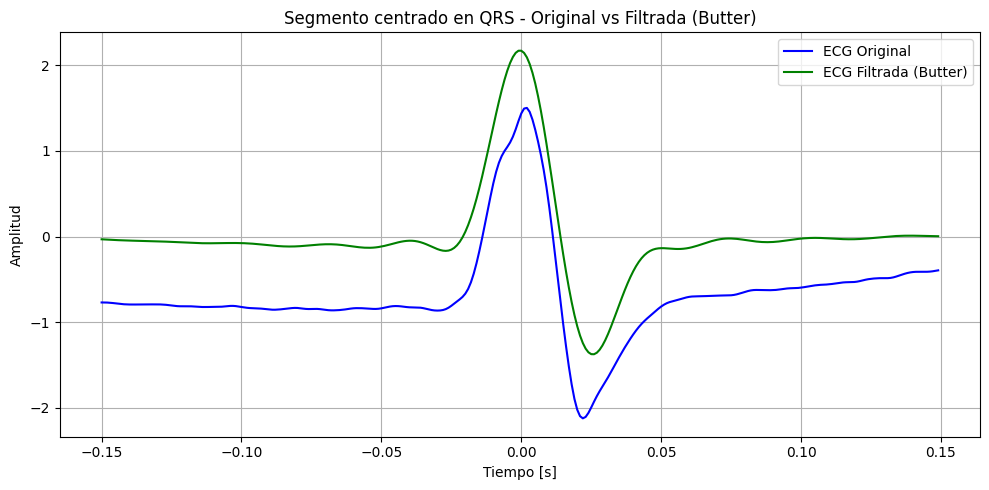

In [65]:
#%% Aplicaci√≥n del filtro justo sobre el QRS

# Centrado en el mismo latido de antes
i = 0
sample_center = int(qrs_locations[i])

# Nueva ventana m√°s ajustada: ¬±150 ms
window_qrs = 0.3  # segundos
N_qrs = int(window_qrs * fs_ecg)

# Extracci√≥n del segmento centrado en el QRS
ecg_segment_qrs = ecg_one_lead[sample_center - N_qrs // 2 : sample_center + N_qrs // 2]
t_qrs = np.arange(-N_qrs//2, N_qrs//2) / fs_ecg

# Filtrado
ecg_filtrada_butter_qrs = sig.sosfiltfilt(mi_sos_butter, ecg_segment_qrs)

# Gr√°fico
plt.figure(figsize=(10, 5))
plt.plot(t_qrs, ecg_segment_qrs, label='ECG Original', color='blue')
plt.plot(t_qrs, ecg_filtrada_butter_qrs, label=f'ECG Filtrada (Butter)', color='green')
plt.title(f'Segmento centrado en QRS - Original vs Filtrada (Butter)')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


La ventana de 0.2 segundos se centr√≥ en la posici√≥n indicada por *qrs_location*, que marca el instante del complejo QRS detectado en la se√±al ECG. Esta regi√≥n representa la despolarizaci√≥n ventricular y es la porci√≥n m√°s energ√©tica y caracter√≠stica del latido card√≠aco, por lo que centrar el an√°lisis all√≠ permite evaluar con mayor claridad el efecto del filtrado sobre la morfolog√≠a del pulso.
Desde el punto de vista biol√≥gico, el complejo QRS tiene una duraci√≥n t√≠pica de entre 0.06 y 0.10 segundos, siendo patol√≥gico si supera los 0.12 segundos. Por eso, una ventana de 0.2 s permite capturar completamente el QRS, junto con un peque√±o margen antes y despu√©s, proporcionando contexto temporal suficiente para observar su forma completa y las posibles distorsiones introducidas por el filtro.

### ----------- Aproximaci√≥n Cauer -----------

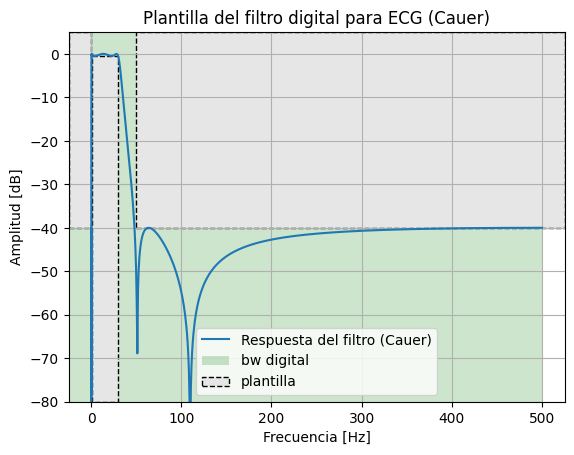

In [66]:
# ----------- Aproximaci√≥n de Cauer (El√≠ptico) -----------
# Descomentar esta l√≠nea para usar El√≠ptico (Cauer, m√≠nima orden)
aprox_name = 'ellip'
mi_sos_ellip = sig.iirdesign(
    wp=[0.5, 30],
    ws=[0.1, 50],
    gpass=0.5,
    gstop=40,
    ftype=aprox_name,
    output='sos',
    fs=fs_ecg
)

fpass = np.array([0.5, 30])      # Banda de paso
fstop = np.array([0.1, 50])      # Banda de detenci√≥n
ripple = 0.5                     # Rizado en banda de paso (dB)
attenuation = 40                # Atenuaci√≥n en banda de detenci√≥n (dB)

# Dise√±o del filtro (estructura en SOS)
mi_sos_ellip = sig.iirdesign(
    wp=fpass,
    ws=fstop,
    gpass=ripple,
    gstop=attenuation,
    ftype=aprox_name,
    output='sos',
    fs=fs_ecg
)


ecg_filtrada_ellip = sig.sosfiltfilt(mi_sos_ellip, ecg_segment)
ecg_filtrada_ellip = ecg_filtrada_ellip / np.std(ecg_filtrada_ellip)

#%% Visualizaci√≥n de plantilla y respuesta en frecuencia

f_low = np.linspace(0.01, 0.4, 300)
f_fine = np.linspace(0.4, 0.6, 500)
f_high = np.linspace(0.6, nyq_frec, 700)
f_total = np.concatenate((f_low, f_fine, f_high))

w_rad = f_total / nyq_frec * np.pi
w, hh = sosfreqz(mi_sos_ellip, worN=w_rad)

plt.figure()
plt.plot(w / np.pi * nyq_frec, 20 * np.log10(np.abs(hh) + 1e-15),
         label=f'Respuesta del filtro (Cauer)')
plt.title(f'Plantilla del filtro digital para ECG (Cauer)')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Amplitud [dB]')
plt.grid(True)
plt.ylim([-80, 5])

plot_plantilla(
    filter_type=filter_type,
    fpass=fpass,
    ripple=ripple,
    fstop=fstop,
    attenuation=attenuation,
    fs=fs_ecg
)

plt.show()


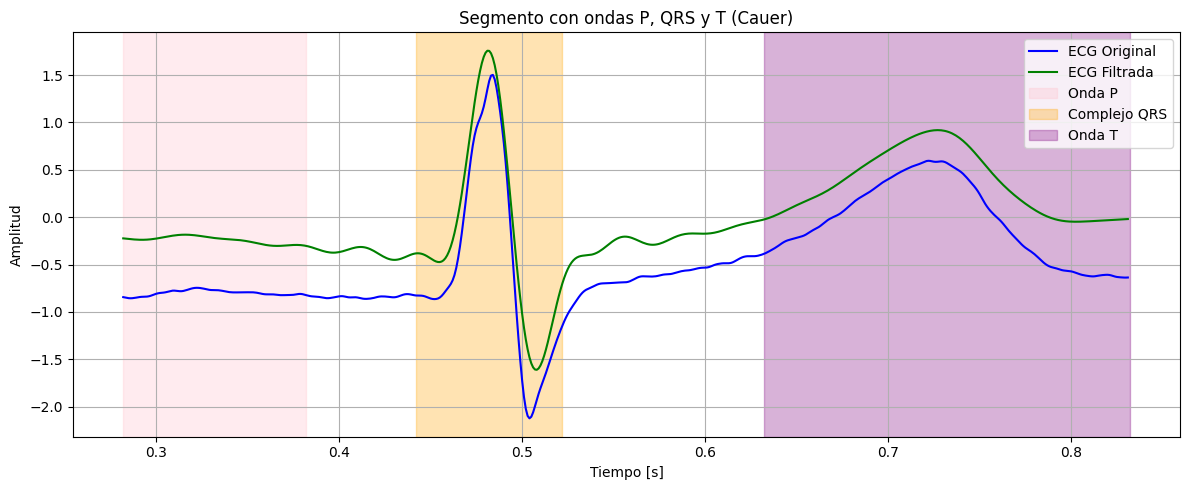

In [67]:
#%% Visualizaci√≥n segmento con ondas P, QRS y T

# Par√°metros para ventanas de las ondas (en segundos)
p_start_sec = -0.2  # 200 ms antes del QRS (inicio P)
p_end_sec = -0.1    # 100 ms antes del QRS (fin P)

qrs_start_sec = -0.04  # 40 ms antes del QRS (inicio QRS)
qrs_end_sec = 0.04     # 40 ms despu√©s del QRS (fin QRS)

t_start_sec = 0.15    # 150 ms despu√©s del QRS (inicio T)
t_end_sec = 0.35      # 350 ms despu√©s del QRS (fin T)

# Muestras relativas
sample_center = int(qrs_locations[0])
p_start = sample_center + int(p_start_sec * fs_ecg)
p_end = sample_center + int(p_end_sec * fs_ecg)

qrs_start = sample_center + int(qrs_start_sec * fs_ecg)
qrs_end = sample_center + int(qrs_end_sec * fs_ecg)

t_start = sample_center + int(t_start_sec * fs_ecg)
t_end = sample_center + int(t_end_sec * fs_ecg)

# Extraemos un segmento amplio para visualizar
start_segment = p_start
end_segment = t_end

ecg_segment_full = ecg_one_lead[start_segment:end_segment]
t_segment_full = np.arange(start_segment, end_segment) / fs_ecg
ecg_filtrada_ellip_full = sig.sosfiltfilt(mi_sos_ellip, ecg_segment_full)

plt.figure(figsize=(12, 5))
plt.plot(t_segment_full, ecg_segment_full, label='ECG Original', color='blue')
plt.plot(t_segment_full, ecg_filtrada_ellip_full, label='ECG Filtrada', color='green')

# Sombreado de las ondas P, QRS y T
plt.axvspan(p_start / fs_ecg, p_end / fs_ecg, color='pink', alpha=0.3, label='Onda P')
plt.axvspan(qrs_start / fs_ecg, qrs_end / fs_ecg, color='orange', alpha=0.3, label='Complejo QRS')
plt.axvspan(t_start / fs_ecg, t_end / fs_ecg, color='purple', alpha=0.3, label='Onda T')

plt.title('Segmento con ondas P, QRS y T (Cauer)')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


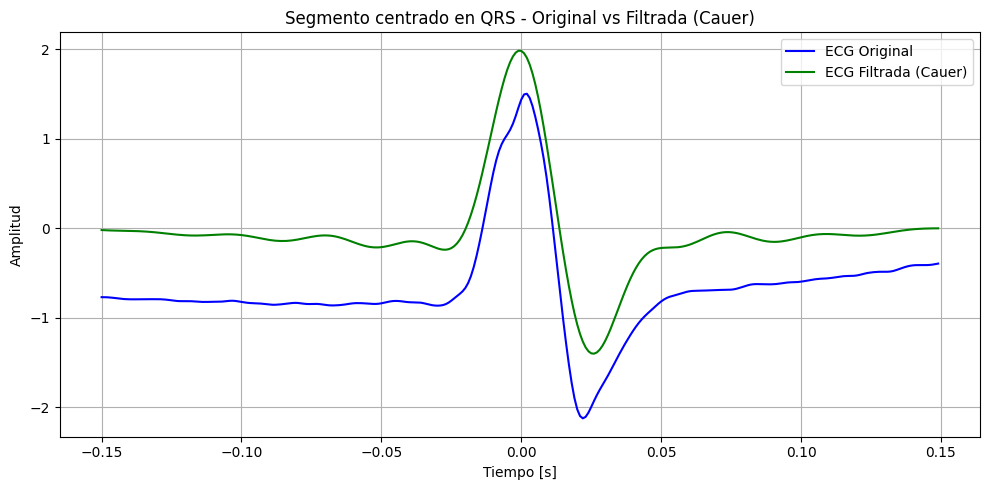

In [68]:
#%% Aplicaci√≥n del filtro justo sobre el QRS

# Centrado en el mismo latido de antes
i = 0
sample_center = int(qrs_locations[i])

# Nueva ventana m√°s ajustada: ¬±150 ms
window_qrs = 0.3  # segundos
N_qrs = int(window_qrs * fs_ecg)

# Extracci√≥n del segmento centrado en el QRS
ecg_segment_qrs = ecg_one_lead[sample_center - N_qrs // 2 : sample_center + N_qrs // 2]
t_qrs = np.arange(-N_qrs//2, N_qrs//2) / fs_ecg

# Filtrado
ecg_filtrada_ellip_qrs = sig.sosfiltfilt(mi_sos_ellip, ecg_segment_qrs)

# Gr√°fico
plt.figure(figsize=(10, 5))
plt.plot(t_qrs, ecg_segment_qrs, label='ECG Original', color='blue')
plt.plot(t_qrs, ecg_filtrada_ellip_qrs, label=f'ECG Filtrada (Cauer)', color='green')
plt.title(f'Segmento centrado en QRS - Original vs Filtrada (Cauer)')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## 2. Filtro FIR

## b) Establecimiento de la plantilla de dise√±o para filtros digitales FIR

Para el dise√±o del filtro FIR pasabanda se consideraron las diferencias clave frente a los filtros IIR. En particular, los filtros FIR suelen tener coeficientes sim√©tricos, lo que les garantiza una **respuesta lineal en fase**. Sin embargo, esta caracter√≠stica limita la flexibilidad en la configuraci√≥n de la plantilla, especialmente en t√©rminos de transiciones abruptas y selectividad, requiriendo un mayor n√∫mero de coeficientes (orden m√°s alto) para lograr especificaciones similares a las de un filtro IIR.

Por esta raz√≥n, para el filtro FIR se decidi√≥ ser m√°s flexible en la definici√≥n de la banda de paso y las transiciones, buscando un **balance entre la complejidad computacional y la calidad del filtrado**.

Se establecieron las siguientes especificaciones para el dise√±o con ventana Kaiser:

- **Banda de paso desde 1 Hz hasta 35 Hz:**  
  Esta banda se seleccion√≥ para preservar los componentes relevantes de la se√±al ECG, como las ondas P y T, mientras se aten√∫an interferencias fuera del rango fisiol√≥gico. Se permite una ligera p√©rdida por debajo de 1 Hz para facilitar la transici√≥n suave propia de filtros FIR.

- **Bandas de rechazo por debajo de 0.1 Hz y por encima de 50 Hz:**  
  Las bandas de detenci√≥n tienen atenuaci√≥n desde 0 hasta 0.1 Hz en el rango inferior y desde 50 Hz hasta la frecuencia de Nyquist, con una atenuaci√≥n objetivo de 40 dB. Se opt√≥ por transiciones menos abruptas para mantener un orden de filtro computacionalmente viable.

- **Orden del filtro: 2000 (2001 coeficientes):**  
  Se eligi√≥ este orden alto para asegurar la selectividad requerida, aceptando la mayor complejidad computacional a cambio de una buena conservaci√≥n de la morfolog√≠a de la se√±al ECG.

- **Ventana Kaiser con beta = 6:**  
  Se utiliz√≥ esta ventana para suavizar el dise√±o del filtro y lograr un buen compromiso entre el ancho de las bandas de transici√≥n y la atenuaci√≥n en las zonas de stopband

Adem√°s, para un dise√±o alternativo con m√≠nimos cuadrados (Least Squares), se definieron estas especificaciones:

- **Banda de paso desde 2 Hz hasta 35 Hz** y bandas de detenci√≥n desde 0 a 0.5 Hz y desde 50 Hz hasta Nyquist.

- **Rizado permitido en banda de paso de 2 dB y atenuaci√≥n en bandas de detenci√≥n de 30 dB.**

- **Orden del filtro: 207 coeficientes**, buscando un compromiso entre calidad y eficiencia computacional.

Esta configuraci√≥n implica un compromiso: la atenuaci√≥n en frecuencias menores a 1 Hz no es tan estricta como en el filtro IIR, pero se prioriza la **conservaci√≥n de la morfolog√≠a** de la se√±al ECG, minimizando distorsiones en las ondas de inter√©s.

A continuaci√≥n, se presenta la plantilla de dise√±o junto con la respuesta en frecuencia de ambos filtros FIR, en las cuales se observa una transici√≥n m√°s gradual en la banda inferior y la preservaci√≥n de las caracter√≠sticas importantes del ECG.


### ----------- M√©todo por ventanas (Kaiser) -----------

.

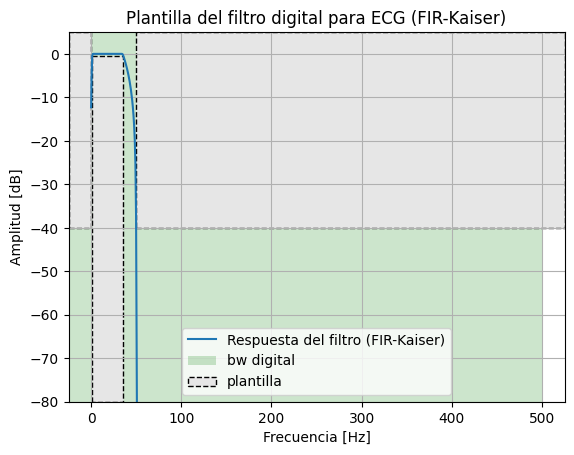

In [69]:
#%% Dise√±o de filtros con FIR - Ventanas

# Par√°metros de la plantilla del filtro 
fpass = np.array([1.3, 35])      # Banda de paso
fs_ecgtop = np.array([0.1, 50])  # Banda de detenci√≥n
ripple = 0.5                    # Rizado en banda de paso (dB)
attenuation = 40                # Atenuaci√≥n en banda de detenci√≥n (dB)

#%% Dise√±o de filtro con firwin2

cant_coef = 2001    # cantidad de coeficientes (orden + 1), ideal impar

nyq = fs_ecg / 2        # frecuencia de Nyquist

# Definimos los puntos de frecuencia y ganancia
#freq_hz = [0.0, 0.5, 1, 40.0, 50.0, nyq] 
freq_hz =[0.0, 0.1, 1, 35.0, 50.0, nyq]  # en Hz
gain =    [0.0, 0.0, 1.0, 1.0, 0.0, 0.0]   # ganancia deseada en cada punto

# Normalizar las frecuencias
freq_norm = [f / nyq for f in freq_hz]

# Dise√±ar el filtro con firwin2
Windows_fir = sig.firwin2(
    numtaps=cant_coef,
    freq=freq_norm,
    gain=gain,
    window=('kaiser', 6)
)

aprox_name = 'FIR-Kaiser' 

f_low = np.linspace(0.01, 0.4, 300)
f_fine = np.linspace(0.4, 0.6, 500)
f_high = np.linspace(0.6, nyq_frec, 700)
f_total = np.concatenate((f_low, f_fine, f_high))

w_rad = f_total / nyq_frec * np.pi
w, hh = sig.freqz(Windows_fir, worN=w_rad)

plt.figure()
plt.plot(w / np.pi * nyq_frec, 20 * np.log10(np.abs(hh) + 1e-15),
         label=f'Respuesta del filtro ({aprox_name})')
plt.title(f'Plantilla del filtro digital para ECG ({aprox_name})')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Amplitud [dB]')
plt.grid(True)
plt.ylim([-80, 5])

plot_plantilla(
    filter_type='bandpass',
    fpass=fpass,
    ripple=ripple,
    fstop=fs_ecgtop,
    attenuation=attenuation,
    fs=fs_ecg
)

plt.show()


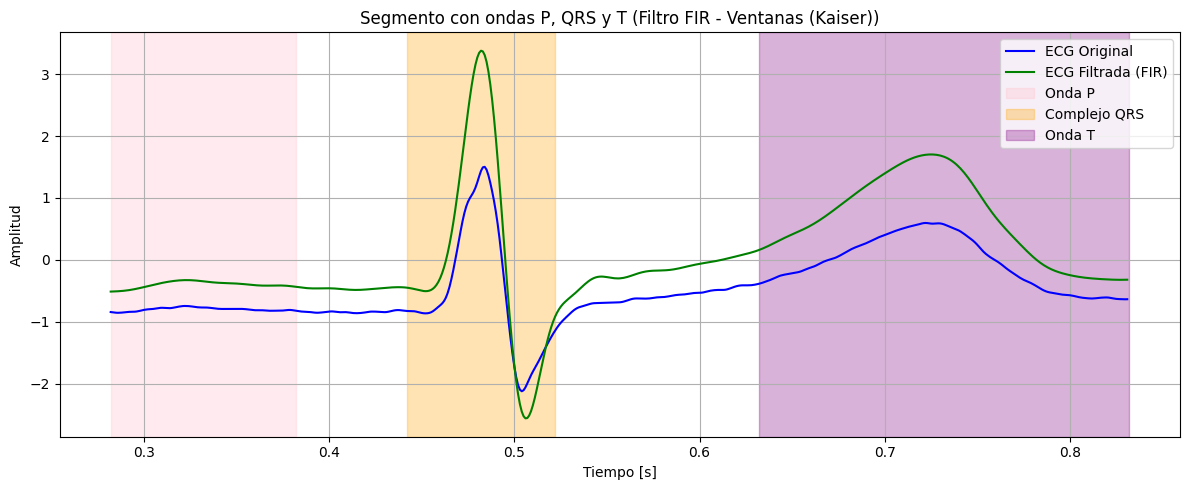

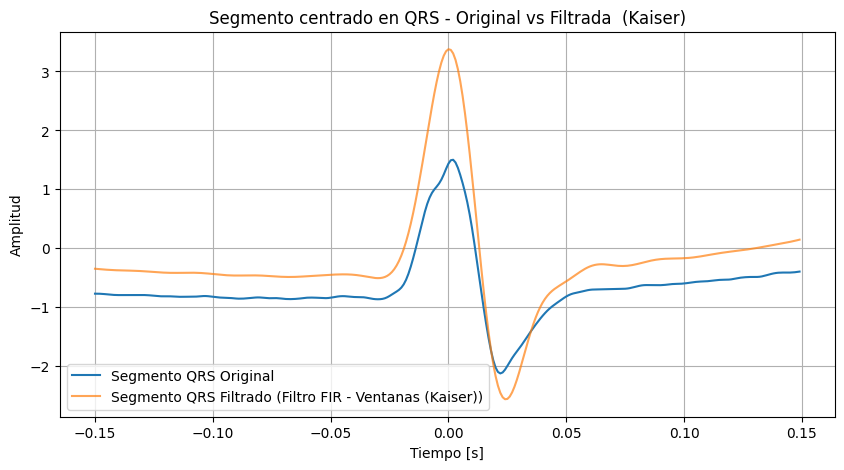

In [70]:
#%% Aplicaci√≥n de filtros

# Filtramos la se√±al
ecg_filtrado_kaiser = sig.lfilter(Windows_fir, 1, ecg_one_lead)
t = np.arange(len(ecg_one_lead)) /fs_ecg


# Aplicaci√≥n de filtros sin retardo con filtfilt
ecg_filtrado_kaiser = sig.filtfilt(Windows_fir, [1], ecg_one_lead)
ecg_filtrado_kaiser=ecg_filtrado_kaiser/np.std(ecg_filtrado_kaiser)

#%% Comparativa se√±ales originales vs filtradas: FIR Kaiser
# Visualizaci√≥n segmento con ondas P, QRS y T usando filtro FIR

# Par√°metros para ventanas de las ondas (en segundos)
p_start_sec = -0.2  # 200 ms antes del QRS (inicio P)
p_end_sec = -0.1    # 100 ms antes del QRS (fin P)

qrs_start_sec = -0.04  # 40 ms antes del QRS (inicio QRS)
qrs_end_sec = 0.04     # 40 ms despu√©s del QRS (fin QRS)

t_start_sec = 0.15    # 150 ms despu√©s del QRS (inicio T)
t_end_sec = 0.35      # 350 ms despu√©s del QRS (fin T)

# Ubicaci√≥n del primer QRS
sample_center = int(qrs_locations[0])

# C√°lculo de √≠ndices en muestras
p_start = sample_center + int(p_start_sec * fs_ecg)
p_end = sample_center + int(p_end_sec * fs_ecg)

qrs_start = sample_center + int(qrs_start_sec * fs_ecg)
qrs_end = sample_center + int(qrs_end_sec * fs_ecg)

t_start = sample_center + int(t_start_sec * fs_ecg)
t_end = sample_center + int(t_end_sec * fs_ecg)

# Extraemos segmento completo para visualizar
start_segment = p_start
end_segment = t_end

ecg_segment_full = ecg_one_lead[start_segment:end_segment]
t_segment_full = np.arange(start_segment, end_segment) / fs_ecg

# Aplicar filtro FIR con lfilter
ecg_filtrada_full = ecg_filtrado_kaiser[start_segment:end_segment]

plt.figure(figsize=(12, 5))
plt.plot(t_segment_full, ecg_segment_full, label='ECG Original', color='blue')
plt.plot(t_segment_full, ecg_filtrada_full, label='ECG Filtrada (FIR)', color='green')

# Sombreado de las ondas P, QRS y T
plt.axvspan(p_start / fs_ecg, p_end / fs_ecg, color='pink', alpha=0.3, label='Onda P')
plt.axvspan(qrs_start / fs_ecg, qrs_end / fs_ecg, color='orange', alpha=0.3, label='Complejo QRS')
plt.axvspan(t_start / fs_ecg, t_end / fs_ecg, color='purple', alpha=0.3, label='Onda T')

plt.title('Segmento con ondas P, QRS y T (Filtro FIR - Ventanas (Kaiser))')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# QRS
# √çndice del latido a analizar
i = 0
sample_center = int(qrs_locations[i])

# Ventana centrada ¬±150 ms
window_qrs = 0.3  # segundos
N_qrs = int(window_qrs * fs_ecg)

# Segmento QRS original (sin filtrar)
ecg_segment_qrs = ecg_one_lead[sample_center - N_qrs // 2 : sample_center + N_qrs // 2]

# Segmento QRS filtrado, extra√≠do de la se√±al filtrada completa
ecg_segment_qrs_filt = ecg_filtrado_kaiser[sample_center - N_qrs // 2 : sample_center + N_qrs // 2]

# Tiempo para la ventana QRS
t_qrs = np.arange(-N_qrs//2, N_qrs//2) / fs_ecg

# Graficar ambos
plt.figure(figsize=(10,5))
plt.plot(t_qrs, ecg_segment_qrs, label='Segmento QRS Original')
plt.plot(t_qrs, ecg_segment_qrs_filt, label='Segmento QRS Filtrado (Filtro FIR - Ventanas (Kaiser))', alpha=0.7)
plt.title('Segmento centrado en QRS - Original vs Filtrada  (Kaiser)')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')
plt.legend()
plt.grid(True)
plt.show()

### ----------- Cuadrados M√≠nimos -----------

Como en este entorno no me es posible ejecutar la funci√≥n `fir_design_ls` de la librer√≠a `pytc2.filtros_digitales`, incluyo a continuaci√≥n las im√°genes del filtro por m√≠nimos cuadrados (LS) que obtuve al correr el c√≥digo localmente.  
De todas maneras, dejo el c√≥digo disponible por si el docente desea ejecutarlo en su propia m√°quina.


In [29]:
#%% Dise√±o de FIR con cuadrados m√≠nimos

# Par√°metros

fs_ecgtop = np.array([0.5, 50])    # Banda de detenci√≥n
fpass = np.array([2, 35])          # Banda de paso
ripple = 2                        # dB (banda de paso)
attenuation = 30                  # dB (banda de detenci√≥n)

# Frecuencias normalizadas (por Nyquist = fs_ecg/2)
fn = fs_ecg / 2
Be = [
    0.0, fs_ecgtop[0]/fn,           # detenci√≥n baja
    fpass[0]/fn, fpass[1]/fn,       # paso
    fs_ecgtop[1]/fn, 1.0            # detenci√≥n alta
]

# Respuesta deseada en cada banda
D = [0, 0, 1, 1, 0, 0]

# Peso relativo (convertido de dB aproximado)
W = [10**(attenuation/20), 1, 10**(attenuation/20)]  # enfatiza la banda de paso

# Estimamos orden (puedes refinar esto)
N = 207 # orden del filtro (ajustable)

# Dise√±o del filtro
lsq_fir = fir_design_ls(order=N, band_edges=Be, desired=D, weight=W, filter_type='m', grid_density=16)

# Evaluamos FFT
fft_sz = 4096
H = np.fft.fft(lsq_fir, fft_sz)
frecuencias = np.linspace(0, fn, fft_sz//2)

# Graficar
plt.figure(figsize=(10, 5))
plt.plot(frecuencias, 20*np.log10(np.abs(H[:fft_sz//2]) + 1e-8), label='Filtro FIR LS')
plt.title("Respuesta en Frecuencia del Filtro FIR Pasabanda")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Magnitud [dB]")
plt.ylim([-80, 5])
plt.grid(True)
plt.legend()
plt.tight_layout()

plot_plantilla(
    filter_type='bandpass',
    fpass=fpass,
    ripple=ripple,
    fstop=fs_ecgtop,
    attenuation=attenuation,
    fs=fs_ecg
)

plt.title(f"Filtro FIR Pasa Banda - Orden {N}")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Magnitud [dB]")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

NameError: name 'fir_design_ls' is not defined

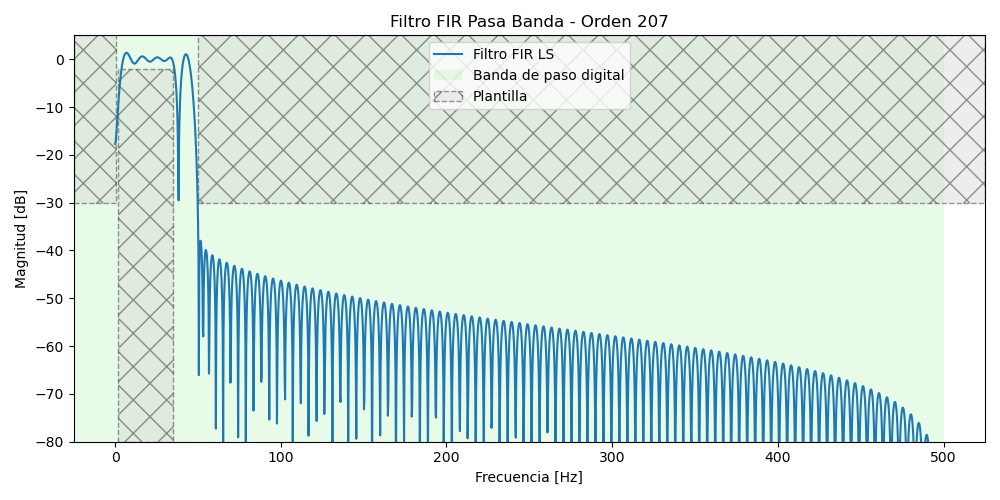

In [4]:
from IPython.display import Image
Image("Plantilla LS.PNG", width=1000, height=600)

In [40]:
#%% Aplicaci√≥n de filtros

# Filtramos la se√±al 

ecg_filtrado_ls = sig.lfilter(lsq_fir, 1, ecg_one_lead)
t = np.arange(len(ecg_one_lead)) /fs_ecg

ecg_filtrado_ls = sig.filtfilt(lsq_fir, [1], ecg_one_lead)
ecg_filtrado_ls=ecg_filtrado_ls/np.std(ecg_filtrado_ls)

#%% Comparativa se√±ales originales vs filtradas: FIR LSQ
#%% Visualizaci√≥n segmento con ondas P, QRS y T usando filtro FIR LSQ

# Par√°metros para ventanas de las ondas (en segundos)
p_start_sec = -0.2  # 200 ms antes del QRS (inicio P)
p_end_sec = -0.1    # 100 ms antes del QRS (fin P)

qrs_start_sec = -0.04  # 40 ms antes del QRS (inicio QRS)
qrs_end_sec = 0.04     # 40 ms despu√©s del QRS (fin QRS)

t_start_sec = 0.15    # 150 ms despu√©s del QRS (inicio T)
t_end_sec = 0.35      # 350 ms despu√©s del QRS (fin T)

# Ubicaci√≥n del primer QRS
sample_center = int(qrs_locations[0])

# C√°lculo de √≠ndices en muestras
p_start = sample_center + int(p_start_sec * fs_ecg)
p_end = sample_center + int(p_end_sec * fs_ecg)

qrs_start = sample_center + int(qrs_start_sec * fs_ecg)
qrs_end = sample_center + int(qrs_end_sec * fs_ecg)

t_start = sample_center + int(t_start_sec * fs_ecg)
t_end = sample_center + int(t_end_sec * fs_ecg)

# Extraemos segmento completo para visualizar
start_segment = p_start
end_segment = t_end

ecg_segment_full = ecg_one_lead[start_segment:end_segment]
t_segment_full = np.arange(start_segment, end_segment) / fs_ecg

# Aplicar filtro FIR con lfilter (ya calculado anteriormente)
ecg_filtrada_full_ls = ecg_filtrado_ls[start_segment:end_segment]

plt.figure(figsize=(12, 5))
plt.plot(t_segment_full, ecg_segment_full, label='ECG Original', color='blue')
plt.plot(t_segment_full, ecg_filtrada_full_ls, label='ECG Filtrada (FIR LSQ)', color='green')

# Sombreado de las ondas P, QRS y T
plt.axvspan(p_start / fs_ecg, p_end / fs_ecg, color='pink', alpha=0.3, label='Onda P')
plt.axvspan(qrs_start / fs_ecg, qrs_end / fs_ecg, color='orange', alpha=0.3, label='Complejo QRS')
plt.axvspan(t_start / fs_ecg, t_end / fs_ecg, color='purple', alpha=0.3, label='Onda T')

plt.title('Segmento con ondas P, QRS y T (Filtro FIR - Cuadrados M√≠nimos)')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

#%% QRS
# √çndice del latido a analizar
i = 0
sample_center = int(qrs_locations[i])

# Ventana centrada ¬±150 ms
window_qrs = 0.3  # segundos
N_qrs = int(window_qrs * fs_ecg)

# Segmento QRS original (sin filtrar)
ecg_segment_qrs = ecg_one_lead[sample_center - N_qrs // 2 : sample_center + N_qrs // 2]

# Segmento QRS filtrado, extra√≠do de la se√±al filtrada completa (LSQ)
ecg_segment_qrs_filt = ecg_filtrado_ls[sample_center - N_qrs // 2 : sample_center + N_qrs // 2]

# Tiempo para la ventana QRS
t_qrs = np.arange(-N_qrs//2, N_qrs//2) / fs_ecg

# Graficar ambos
plt.figure(figsize=(10,5))
plt.plot(t_qrs, ecg_segment_qrs, label='Segmento QRS Original')
plt.plot(t_qrs, ecg_segment_qrs_filt, label='Segmento QRS Filtrado (Filtro FIR - Cuadrados M√≠nimos)', alpha=0.7)
plt.title(f'Segmento QRS Filtrado (Filtro FIR - Ventanas (Cuadrados M√≠nimos))')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')
plt.legend()
plt.grid(True)
plt.show()

NameError: name 'lsq_fir' is not defined

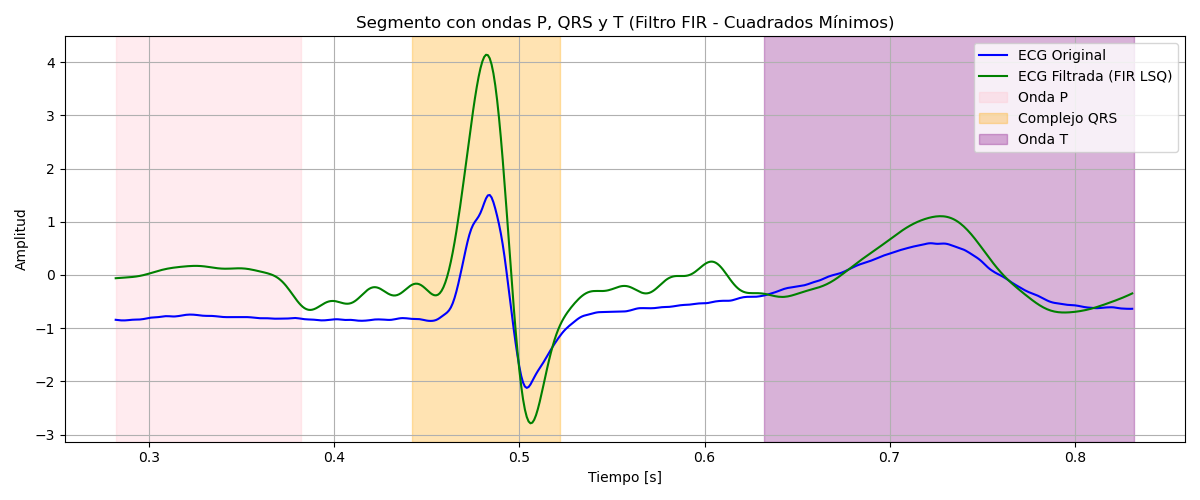

In [3]:
from IPython.display import Image
Image("P, QRS T LS.PNG", width=1000, height=600)

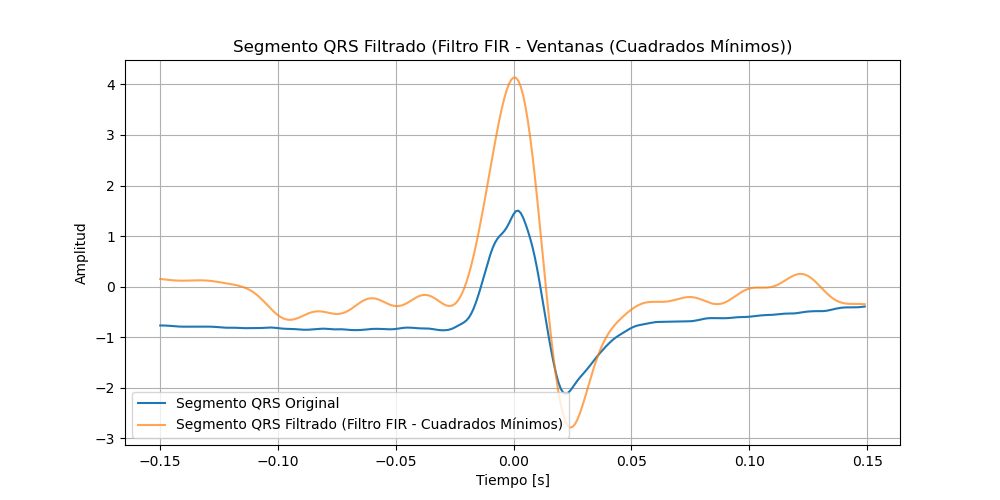

In [5]:
from IPython.display import Image
Image("QRS LS.PNG", width=1000, height=600)

### D) Evaluaci√≥n del rendimiento de los filtros

NameError: name 'ecg_filtrado_ls' is not defined

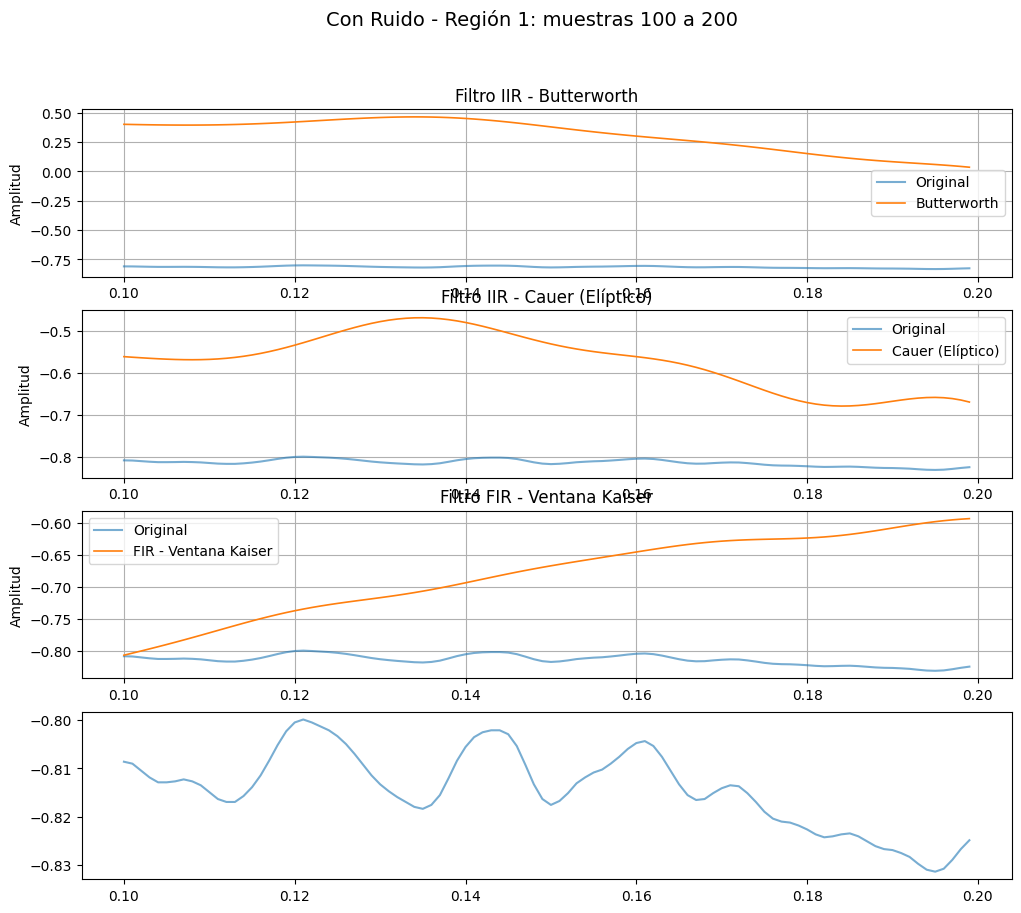

In [74]:
#%% An√°lisis de regiones de inter√©s con se√±ales filtradas

cant_muestras = len(ecg_one_lead)

# Duraci√≥n total en segundos
dur_total = cant_muestras / fs_ecg

# Definir regiones con ruido (en muestras) dentro del rango v√°lido
regs_ruido = (
    [100, 200],   # ejemplo: muestras 100 a 200 (0.1s a 0.2s)
    [300, 400],   # ejemplo: muestras 300 a 400 (0.3s a 0.4s)
)

# Definir regiones sin ruido (en segundos, convertido a muestras)
regs_sin_ruido = (
    np.array([0.1, 0.2]) * fs_ecg,   # 0.1 a 0.2 segundos
    np.array([0.4, 0.5]) * fs_ecg,   # 0.4 a 0.5 segundos
    np.array([0.5, 0.6]) * fs_ecg,   # 0.5 a 0.6 segundos
)

regiones = [("Con Ruido", regs_ruido), ("Sin Ruido", regs_sin_ruido)]

min_len = 50  # m√≠nimo largo de regi√≥n en muestras para graficar

for tipo_region, lista_regiones in regiones:
    for i, reg in enumerate(lista_regiones):
        reg = np.array(reg, dtype=int)
        start_idx, end_idx = reg[0], reg[1]

        # Verifico si la regi√≥n est√° dentro de la se√±al y tiene un tama√±o m√≠nimo
        if start_idx < 0 or end_idx > cant_muestras or (end_idx - start_idx) < min_len:
            print(f"Regi√≥n inv√°lida para {tipo_region} - Regi√≥n {i+1}, la salto.")
            continue

        zoom_region = np.arange(start_idx, end_idx)
        t_zoom = t_total[zoom_region]

        plt.figure(figsize=(12, 10))
        plt.suptitle(f'{tipo_region} - Regi√≥n {i+1}: muestras {start_idx} a {end_idx}', fontsize=14)

        plt.subplot(4, 1, 1)
        plt.plot(t_zoom, ecg_one_lead[zoom_region], label='Original', alpha=0.6)
        plt.plot(t_zoom, ecg_filtrada_butter[zoom_region], label='Butterworth', linewidth=1.2)
        plt.title('Filtro IIR - Butterworth')
        plt.ylabel('Amplitud')
        plt.grid(True)
        plt.legend()

        plt.subplot(4, 1, 2)
        plt.plot(t_zoom, ecg_one_lead[zoom_region], label='Original', alpha=0.6)
        plt.plot(t_zoom, ecg_filtrada_ellip[zoom_region], label='Cauer (El√≠ptico)', linewidth=1.2)
        plt.title('Filtro IIR - Cauer (El√≠ptico)')
        plt.ylabel('Amplitud')
        plt.grid(True)
        plt.legend()

        plt.subplot(4, 1, 3)
        plt.plot(t_zoom, ecg_one_lead[zoom_region], label='Original', alpha=0.6)
        plt.plot(t_zoom, ecg_filtrado_kaiser[zoom_region], label='FIR - Ventana Kaiser', linewidth=1.2)
        plt.title('Filtro FIR - Ventana Kaiser')
        plt.ylabel('Amplitud')
        plt.grid(True)
        plt.legend()

        plt.subplot(4, 1, 4)
        plt.plot(t_zoom, ecg_one_lead[zoom_region], label='Original', alpha=0.6)
        plt.plot(t_zoom, ecg_filtrado_ls[zoom_region], label='FIR - M√≠nimos Cuadrados', linewidth=1.2)
        plt.title('Filtro FIR - M√≠nimos Cuadrados')
        plt.xlabel('Tiempo [s]')
        plt.ylabel('Amplitud')
        plt.grid(True)
        plt.legend()

        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

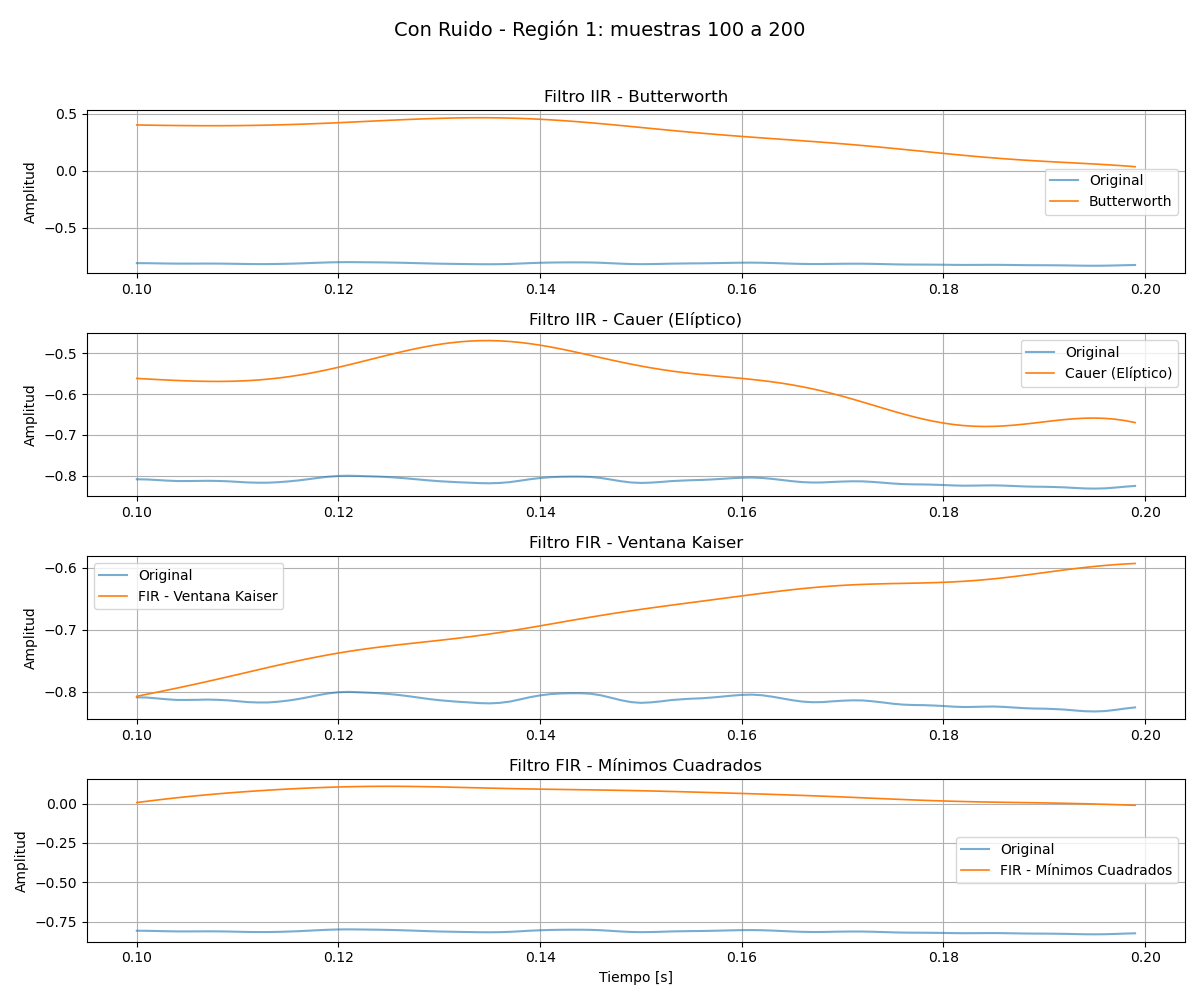

In [7]:
from IPython.display import Image
Image("Regi√≥n 1.PNG", width=1000, height=600)


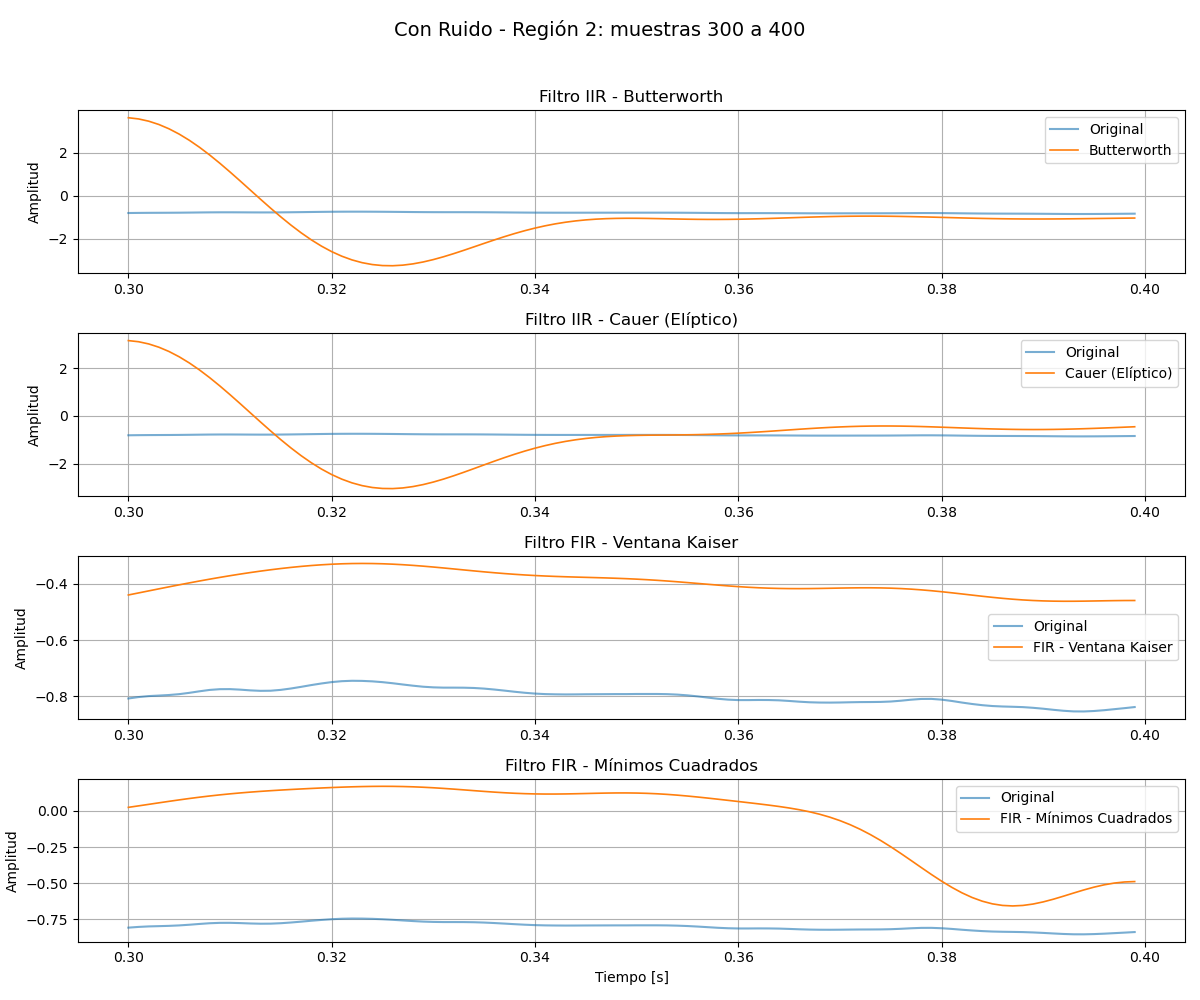

In [8]:

from IPython.display import Image
Image("Regi√≥n 2.PNG", width=1000, height=600)


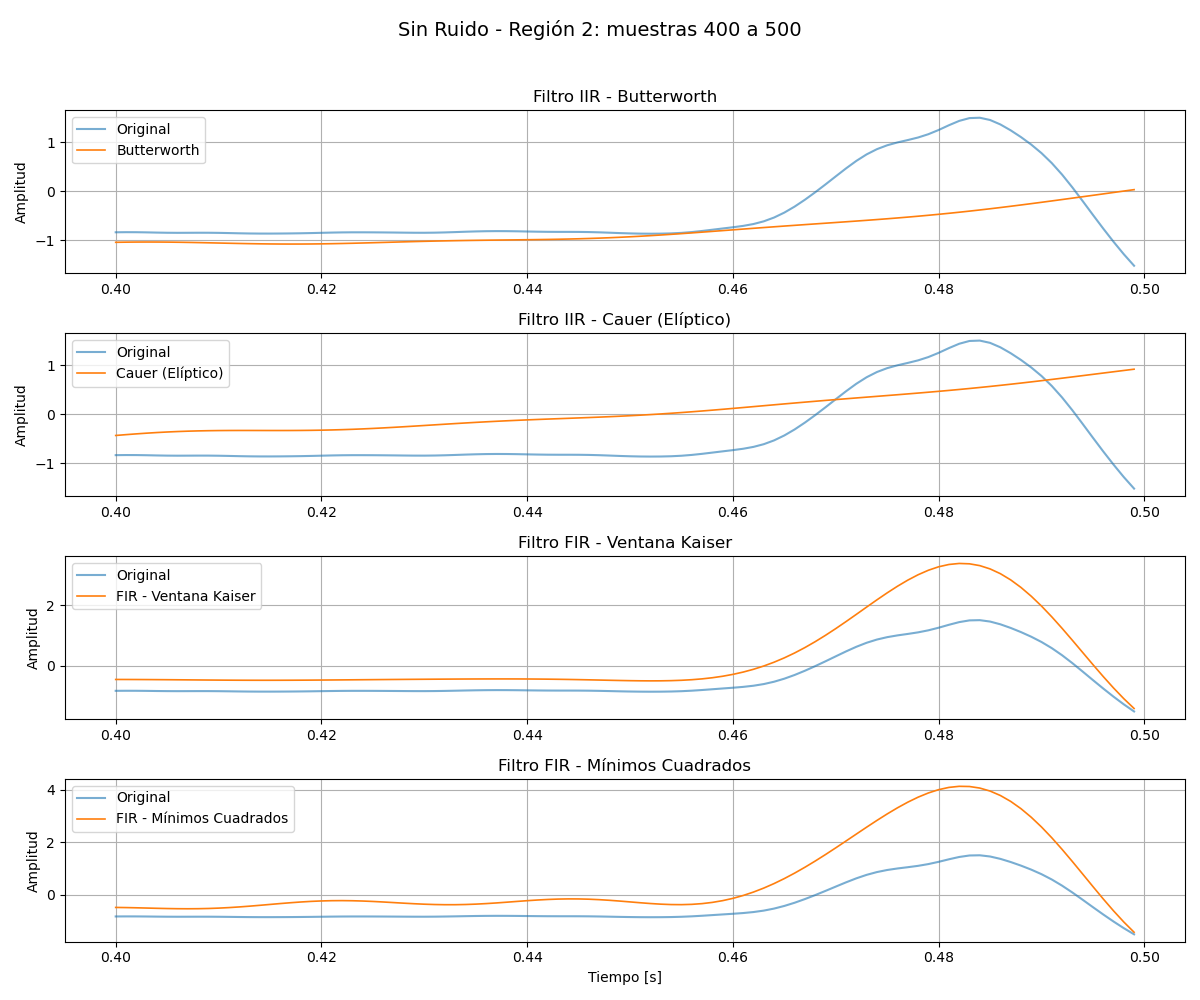

In [9]:

from IPython.display import Image
Image("Regi√≥n 2.2.PNG", width=1000, height=600)



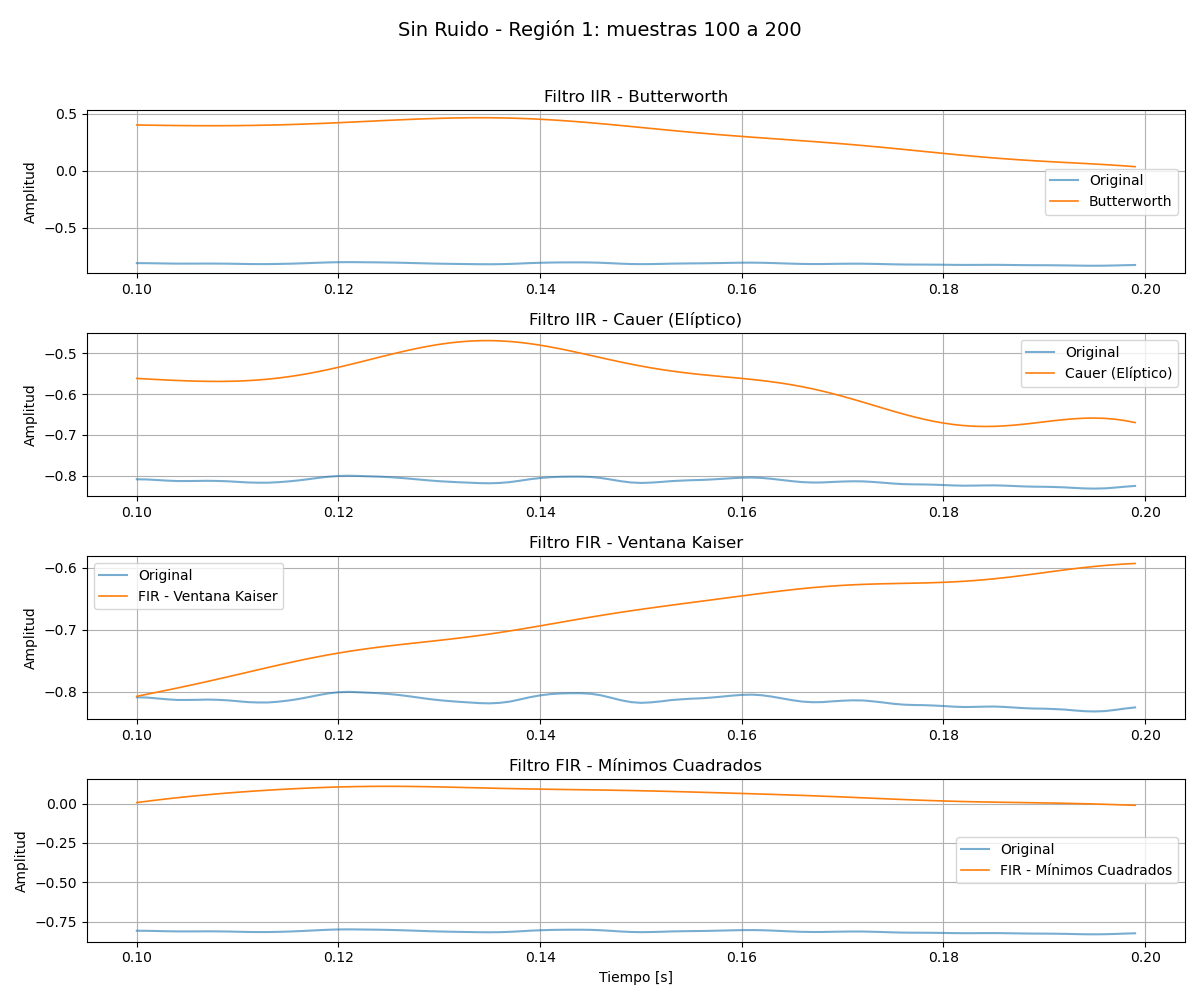

In [10]:
from IPython.display import Image
Image("Regi√≥n 3.PNG", width=1000, height=600)



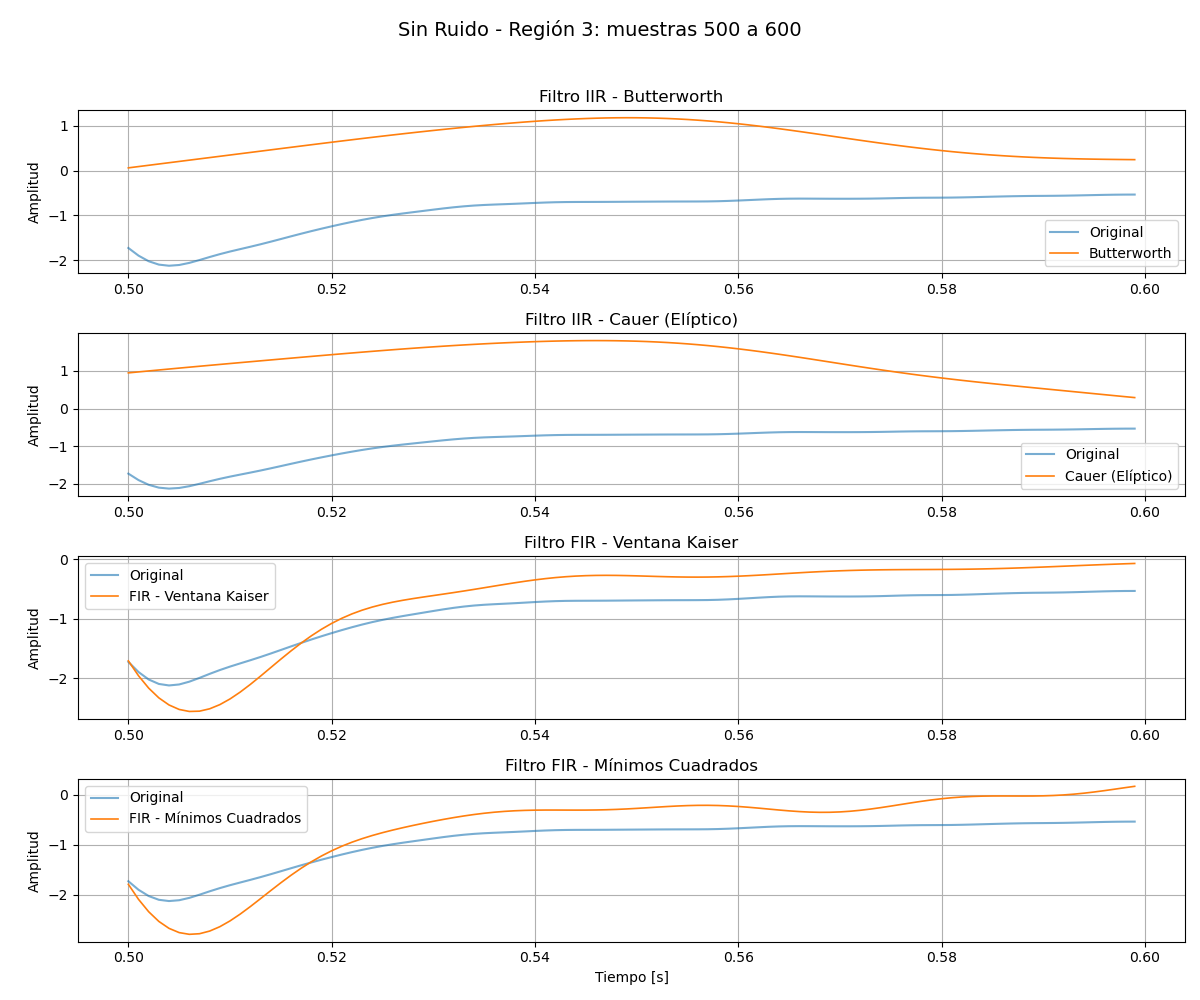

In [12]:
from IPython.display import Image
Image("Regi√≥n 3.2.PNG", width=1000, height=600)

# An√°lisis del rendimiento de los filtros dise√±ados


A continuaci√≥n se analiza el comportamiento de los filtros en t√©rminos de capacidad de filtrado y preservaci√≥n de la morfolog√≠a de la se√±al ECG, considerando distintos segmentos fisiol√≥gicos y regiones con y sin interferencias.

## 1. Segmento QRS (latido aislado)
El complejo QRS es el componente de mayor energ√≠a y contiene las frecuencias m√°s altas del ECG. Por eso, es particularmente sensible al rizado en banda de paso y a distorsiones en la pendiente.

- Butterworth: fue el que mejor conserv√≥ la forma del QRS. Las pendientes ascendentes y descendentes se mantienen suaves, sin introducci√≥n de rizado ni p√©rdida de amplitud. Esto se debe a que este filtro tiene una respuesta mon√≥tona en banda de paso, ideal para preservar la morfolog√≠a.

- Cauer (El√≠ptico): aunque logra una atenuaci√≥n m√°s selectiva, su mayor rizado en banda de paso genera peque√±as ondulaciones en el QRS. Esto se traduce en distociones de alta frecuencia justo donde m√°s precisi√≥n se necesita. Es eficaz contra el ruido, pero menos delicado.

- FIR - Ventana Kaiser: mantiene la forma general del QRS con buena alineaci√≥n temporal (fase lineal), pero la respuesta m√°s abrupta de la ventana produce un QRS m√°s picudo y menos suave que los IIR. La ventaja es que no introduce distorsi√≥n de fase.

- FIR - M√≠nimos Cuadrados (LS): es el que mostr√≥ mayor distorsi√≥n. Las pendientes del QRS aparecen deformadas y con oscilaciones alrededor del trazo de la se√±l original, resultado de una respuesta m√°s fuerte en las transiciones y menor control del rizado. Requiere un orden mucho mayor para obtener resultados similares a un IIR.

Conclusi√≥n: El filtro Butterworth es el que mejor funcionaen este segmento, por su suavidad y precisi√≥n en la conservaci√≥n morfol√≥gica.

## 2.  Segmento completo P - QRS - T (latido completo)
Este an√°lisis incluye las ondas de baja amplitud P y T, as√≠ como el segmento isoel√©ctrico. Aqu√≠ el objetivo es evitar tanto la atenuaci√≥n excesiva como las distorsiones temporales.

- Butterworth: las tres ondas son claramente distinguibles, con trazos suaves y sin distoci√≥n. La l√≠nea base se mantiene estable. 

- Cauer (El√≠ptico): la onda P muestra un leve rizado, y la T presenta oscilaciones. Esto es caracter√≠stico del rizado de los filtros IIR m√°s selectivos. Aunque el ruido est√° bien controlado, la morfolog√≠a m√°s delicada se ve afectada.

- FIR - Ventana Kaiser: muy buen desempe√±o general. Gracias a su fase lineal, todas las ondas mantienen su posici√≥n temporal relativa. Las pendientes son algo m√°s abruptas, pero la morfolog√≠a es clara. 

- FIR - M√≠nimos Cuadrados: logra preservar las tres ondas, pero con mayor atenuaci√≥n en las componentes de baja energ√≠a. Esto provoca que las ondas P y T se vean m√°s planas, y el nivel isoel√©ctrico presente ondulaciones. Esto es consistente con su menor control de la forma en frecuencias bajas.

Conclusi√≥n: En este segmento, el FIR-Kaiser se destaca por su fidelidad temporal y buena conservaci√≥n de la morfolog√≠a completa, aunque el Butterworth tambi√©n ofrece un desempe√±o muy bueno.

## 3. Regiones con ruido 
Estas regiones contienen fuertes componentes interferentes, como ruido muscular o desplazamientos de l√≠nea base.

- Butterworth: excelente supresi√≥n de alta y baja frecuencia. La se√±al se mantiene estable con trazos suaves.
- Cauer: es el m√°s efectivo sacando interferencias gracias a su mayor selectividad, pero eso trae como consecuencia un rizado m√°s visible, sobre todo en las zonas m√°s planas.
- FIR-Kaiser: buena reducci√≥n del ruido, aunque requiere m√°s muestras para estabilizarse por su orden elevado.
- FIR-LS: aten√∫a algo de ruido, pero es el que deja pasar m√°s distorci√≥n. Las transiciones no son tan n√≠tidas.


## 4. Regiones sin ruido 
Estas regiones son √∫tiles para verificar si el filtro distorsiona innecesariamente la se√±al.

- Butterworth: mantiene la morfolog√≠a con trazos suaves y nivel isoel√©ctrico constante.  No mete oscilaciones ni desfases.
- Cauer: aunque no distorsiona la se√±al de forma dr√°stica, el rizado que tiene puede hacer que ciertas partes planas no se vean tan limpias, lo que puede confundir al analizar.
- FIR-Kaiser: probablemente el mejor en esta parte. Gracias a su fase lineal y buena definici√≥n, conserva la morfolog√≠a, la amplitud y el tiempo de las ondas sin agregar informaci√≥n.
- FIR-LS: conserva la se√±al sin distorsiones visibles,  pero se nota que baja un poco la amplitud en las ondas m√°s chiquitas.




# Conclusi√≥n

La tarea me permiti√≥ comparar distintos enfoques de filtrado digital para el procesamiento de se√±ales ECG, destacando las fortalezas y limitaciones de los filtros IIR y FIR en contextos reales con interferencias fisiol√≥gicas y de entorno.

Los filtros IIR, como Butterworth y Cauer, demostraron ser altamente eficientes para aplicaciones donde se requiere una fuerte atenuaci√≥n con bajo costo computacional. Butterworth, en particular, ofreci√≥ un muy buen equilibrio entre supresi√≥n de ruido y conservaci√≥n de la morfolog√≠a, gracias a su transici√≥n suave y respuesta en frecuencia estable. Cauer, por su parte, result√≥ m√°s selectivo y eficaz en ambientes muy ruidosos, aunque con el costo de introducir mayor rizado en banda de paso, lo que puede distorsionar la morfolog√≠a de las ondas m√°s suaves como la P y la T.

Por otro lado, los filtros FIR, especialmente el dise√±ado con ventana de Kaiser, ofrecieron la ventaja fundamental de una fase lineal constante, preservando la alineaci√≥n temporal de las ondas ECG y evitando el desfasaje temporal t√≠pico de los filtros IIR. Esta caracter√≠stica, sin embargo, implica un mayor orden de filtro y, por ende, una mayor carga computacional. Adem√°s, dado que la se√±al ECG presenta un amplio rango de frecuencias importantes, resulta dif√≠cil dise√±ar un filtro FIR √∫nico que satisfaga todos los requisitos de atenuaci√≥n y transici√≥n. En este sentido, y siguiendo un comentario del docente sobre filtros FIR pasa banda, intent√© implementar un filtro en cascada combinando un pasa bajos y un pasa altos, de modo que la respuesta total fuera la convoluci√≥n de ambas respuestas. Sin embargo, la respuesta resultante de la convoluci√≥n me daba cero, y dado que el c√≥digo, de la convoluci√≥n de ambos filtros, no fue visto en clase, opte por dise√±ar directamente un filtro pasa banda FIR.

Para mi sorpresa, el filtro FIR dise√±ado mediante el m√©todo de m√≠nimos cuadrados (LS), pese a ser conceptualmente m√°s robusto para aproximar una respuesta ideal, mostr√≥ un desempe√±o inferior al m√©todo de ventanas en este contexto. Al analizar el efecto del orden ùëÅ en el dise√±o por m√≠nimos cuadrados, se observ√≥ que para valores bajos (por ejemplo, N=50) la se√±al filtrada se asemeja mucho a la original, aunque con limitada capacidad para aproximar la plantilla deseada. Al aumentar ùëÅ (ej. ùëÅ=150), el filtro ajusta mejor la respuesta, manteniendo similitud con la se√±al original. Sin embargo, con √≥rdenes a√∫n mayores (ej. ùëÅ=207 y superiores), el filtro optimiza globalmente la respuesta, pero comienza a ‚Äúcruzar‚Äù parcialmente la plantilla entre puntos espec√≠ficos.

Este fen√≥meno ocurrio especialmente en la zona de bajas frecuencias y puede atribuirse a la naturaleza FIR del filtro, que dificulta la implementaci√≥n de transiciones abruptas o muy ajustadas en un rango de frecuencia tan amplio como el del ECG. Por ello, el filtro debe comprometerse entre la fidelidad en toda la banda, generando estos cruces o desviaciones locales en la plantilla para mantener un ajuste global aceptable.

La optimizaci√≥n LS minimiza el error cuadr√°tico total en toda la banda, permitiendo desviaciones locales para mejorar el ajuste global. Esto provoca que la se√±al filtrada se aleje m√°s de la original. Este ‚Äúcruce parcial‚Äù es un compromiso que hice consciente: priorice el ajuste global y cumplimiento de especificaciones, aceptando desviaciones puntuales, para evitar un sobreajuste que degrade la respuesta general.

En contraste, el m√©todo de ventanas, aunque menos √≥ptimo, produce respuestas m√°s suaves y controladas al limitar las oscilaciones y picos abruptos, favoreciendo una mejor preservaci√≥n morfol√≥gica en la se√±al ECG.

En lo personal me cost√≥ bastante m√°s dise√±ar los filtros FIR que los IIR. Creo que tiene que ver con la naturaleza de la se√±al y tambi√©n porque no us√© un filtro en cascada, que Mariano coment√≥ que suele ayudar bastante en ese tipo de casos. Definir los par√°metros para los FIR se me hizo mucho m√°s complicado, y siento que son filtros m√°s ‚Äúlaxos‚Äù con respecto a la plantilla, no tan estrictos como los IIR.

